Written by AI22BTECH11001

In [1]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os


/home/aviator98/anaconda3/envs/python3.11_env/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/aviator98/anaconda3/envs/python3.11_env/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [6]:
model = models.resnet18(pretrained=True)
model = model.to(device)
model.eval()

num_params = sum(p.numel() for p in model.parameters())
print(num_params)

11689512


In [4]:
import json
import urllib.request

url = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
imagenet_labels = urllib.request.urlopen(url).read().decode("utf-8").splitlines()

print(imagenet_labels[:5])

['tench', 'goldfish', 'great white shark', 'tiger shark', 'hammerhead']


In [5]:
def random_class():
    class_id = np.random.randint(0, 1000)
    print(f"Class ID: {class_id}")
    print(f"Class Name: {imagenet_labels[class_id]}")
    return class_id

random_class()

Class ID: 258
Class Name: Samoyed


258

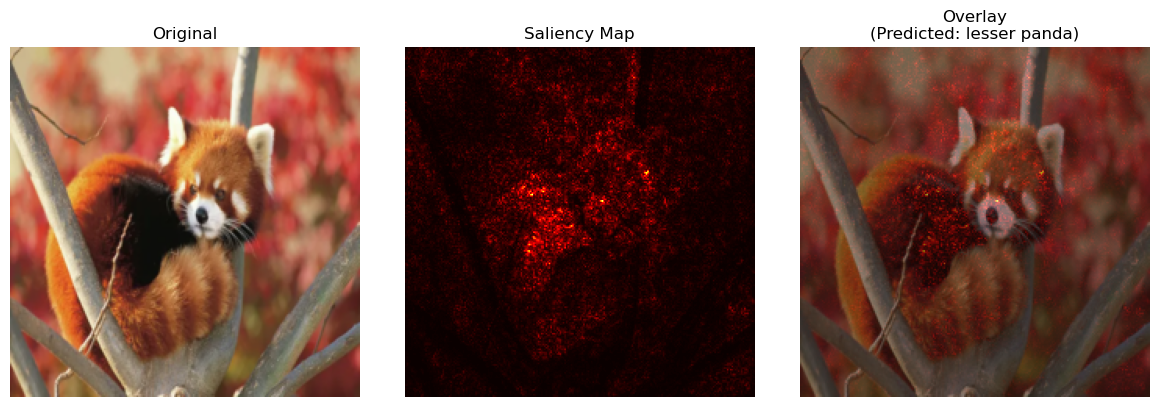

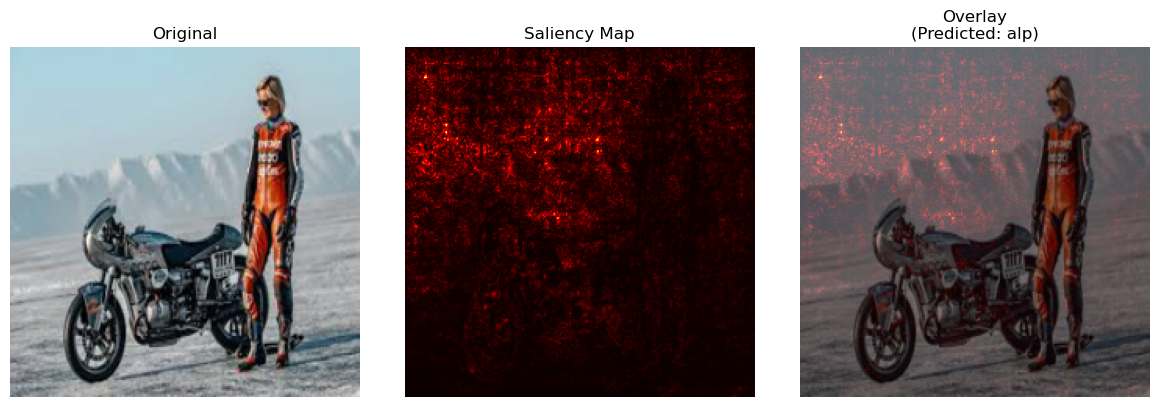

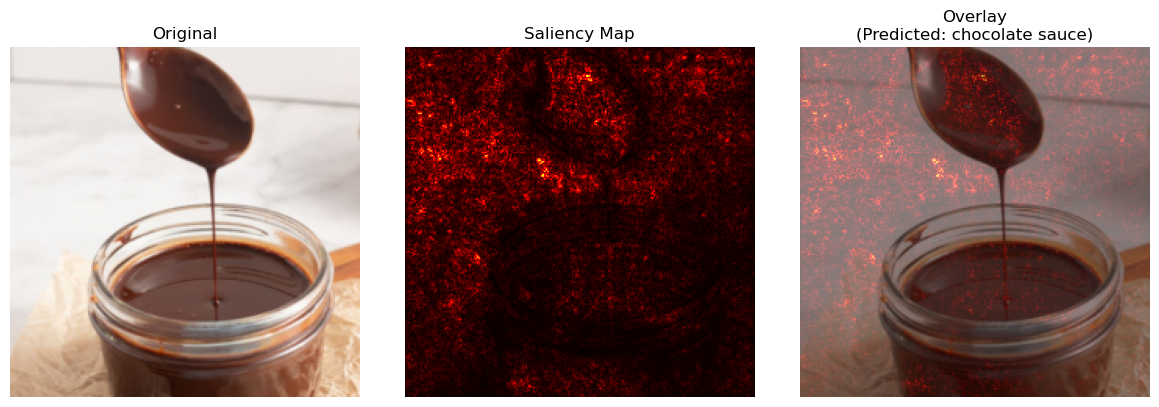

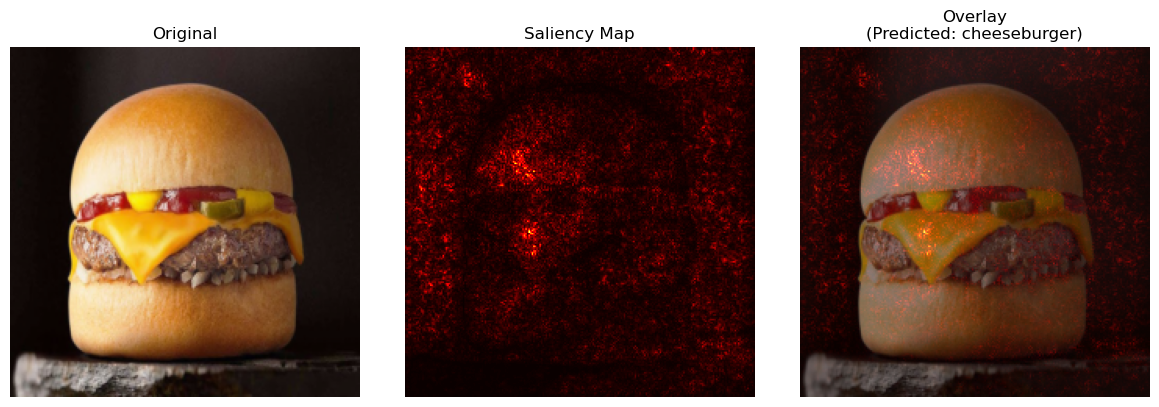

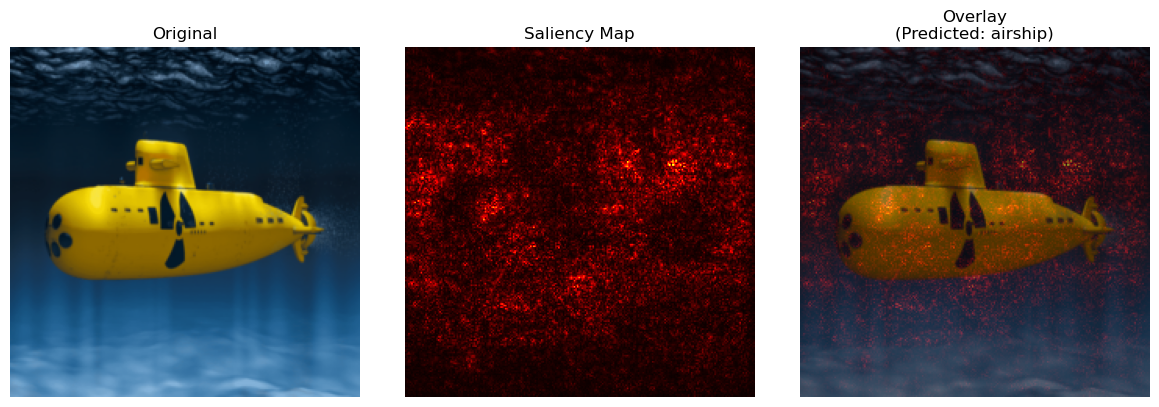

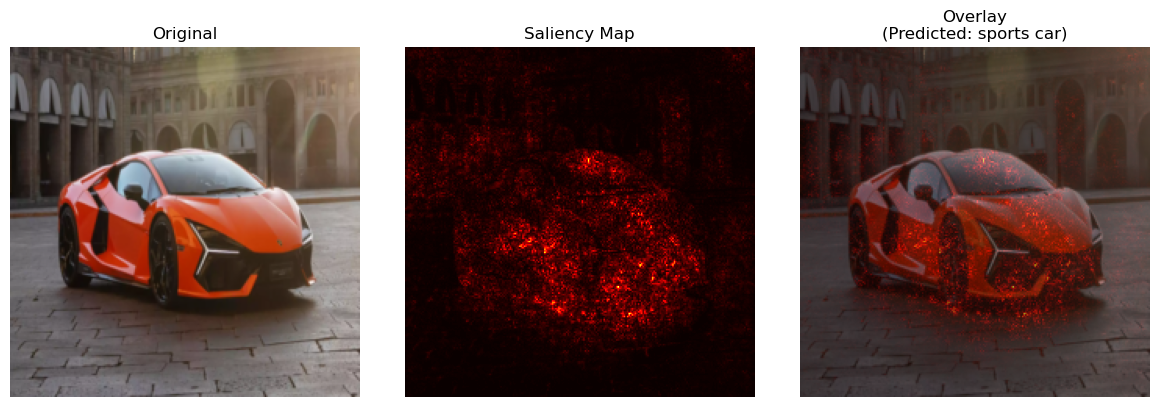

In [9]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torchvision import transforms

# ImageNet normalization stats
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

# Image preprocessing pipeline
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean.tolist(), std=std.tolist())
])

# Directory where images are stored
image_dir = './images/'
image_filenames = [f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.png'))]

# Visualize saliency for each image
for idx, filename in enumerate(image_filenames):
    image_path = os.path.join(image_dir, filename)
    orig_image = Image.open(image_path).convert('RGB')
    
    # Preprocess and add batch dimension
    input_tensor = preprocess(orig_image).unsqueeze(0).to(device)
    input_tensor.requires_grad = True

    # Forward pass
    output = model(input_tensor)
    pred_class = output.argmax().item()

    # Backward to get gradients
    model.zero_grad()
    output[0, pred_class].backward()

    # Saliency map = input * gradient
    gradient = input_tensor.grad.data
    saliency = input_tensor.data * gradient

    # Process saliency
    saliency = saliency.abs().squeeze().cpu().numpy()
    saliency = np.max(saliency, axis=0)
    saliency = (saliency - saliency.min()) / (saliency.max() - saliency.min())

    # Get de-normalized image
    img_np = input_tensor.squeeze().cpu().detach().numpy()
    img_np = img_np.transpose(1, 2, 0)
    img_np = std * img_np + mean
    img_np = np.clip(img_np, 0, 1)

    # Plot original + saliency + overlay
    fig, ax = plt.subplots(1, 3, figsize=(12, 4))

    ax[0].imshow(img_np)
    ax[0].set_title("Original")
    ax[0].axis("off")

    ax[1].imshow(saliency, cmap='hot')
    ax[1].set_title("Saliency Map")
    ax[1].axis("off")

    ax[2].imshow(img_np)
    ax[2].imshow(saliency, cmap='hot', alpha=0.5)
    ax[2].set_title(f"Overlay\n(Predicted: {imagenet_labels[pred_class]})")
    ax[2].axis("off")

    plt.tight_layout()
    plt.show()
